# Antwerp Dataset 
###### Author: Pranay manikanta Narava

- Description : Our current project involves the analysis of breathing audio to predict the presence of wheezes and crackles, utilizing a machine learning model. Specifically, we are implementing a "CNN" (Convolutional Neural Network) Model, to accurately predict respiratory issues by analyzing the breathing audio in question. This approach allows for a more comprehensive and accurate assessment of any potential respiratory concerns, enabling us to better address and treat any issues that may arise. 

## Step - 1
Importing Libraries & Mounting Data

### Importing Required Libraries

To perform the Tasks such as Feature Extraction, Model building, and model analysis   

os : mounting Data  
matplot : for Graphs  
Librosa : for Loading the audio data in array form and Feature Extraction  
pandas : for dataframe  
IPython.display : to play the audio file   
sklearn : to Split the data and to caluculate the model precision, recall, and accuracy   
Tensorflow : for model building 

In [1]:
import os
import matplotlib.pyplot as plt
import librosa
import librosa.display
import pandas as pd 
import numpy as np
import IPython.display as ipd
import soundfile as sf
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.utils import to_categorical                                                                       
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score
from sklearn.metrics import classification_report

2023-09-28 17:38:17.445982: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 17:38:18.327708: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-09-28 17:38:18.327824: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-09-28 17:38:18.327836: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

### Mounting the Dataset Folder from Azure Storage to Notebook
This Python code demonstrates how to set up an Azure Machine Learning (Azure ML) workspace, retrieve data from a registered datastore, create a dataset from specific files, and mount the dataset. These steps are essential for data preparation and management in Azure ML.

In [2]:
from azureml.core import Workspace, Dataset, Datastore
subscription_id = '6a181d75-cf16-43f7-8e7d-4cf2ca9d743c'
resource_group = 'training'
workspace_name = 'sonavi_training'
  
workspace = Workspace(subscription_id, resource_group, workspace_name)
  
datastore = Datastore.get(workspace, "training_data")
dataset = Dataset.File.from_files(path=(datastore, 'data/raw_audios/Antwerp_Simulated/'))
mounted_path = dataset.mount()

In [3]:
# Mounting is asynchronous,
mounted_path.start()

# Access the mounted path
mounted_data_path = mounted_path.mount_point
data_files = os.listdir(mounted_data_path)

## STEP - 2
EDA, Feature Extraction & Visualizations

#### Dataset 
Description: This Data Set folder contains 3600 files in that 1800 files are Audio files and remaining 1800 files are labels to the audio files 
every Audio files is in a .wav format and the duration of each audio files is between 49.163000 sec to 21.559750 sec and these Audio files are Segmented Accordingly and this segmented details was mentioned in the Text files (Labels) and Finally These Audio files are also not segmented in a order 

example:  the text file contains   
00.00 --	 02.91 -->	 0  -- 0   
02.91 --	 04.98 -->	 0 	-- 0   
04.98 --	 07.68 -->	 0 	-- 0   
07.68 --	 09.81 -->	 0 	-- 0   
09.81 --	 12.07 -->	 0 	-- 0   
12.07 --	 14.65 -->	 0 	-- 0   
14.65 --	 17.29 -->	 0 	-- 0   
17.29 --	 19.82 -->	 0 	-- 0    
19.82 --	 22.51 -->	 0 	-- 0   
22.51 --	 25.07 --> 	 0 	-- 0   
As you can see each Audio file is not segment with fixed time 



#### EDA 
Exploratory Data Analysis (EDA) is a critical step in the data analysis process that involves the initial investigation and visualization of data to understand its characteristics, patterns, and potential insights. as we go further into the dataset we will explore insigths of the Audio file and text file 


#### Extracting the Features

In this critical step, we are meticulously extracting the necessary features, such as Mel spectrogram and MFCC, in order to facilitate the development of our model. This process requires thorough attention to detail and precision to ensure that the final product is of the highest quality. By carefully selecting and extracting these specific features, we can optimize the performance of our model and achieve our desired outcomes.


In [4]:
n_mels = 128      # Number of Mel bins
n_fft = 2048      # Number of FFT points for STFT computation
hop_length = 512  # Number of samples between frames

In [5]:
audio_extensions = ['.wav']  # Type of audio file extensions
text_extensions = ['.txt']    # Type of text file extensions
processed_data = []
User_ID_list = []



for audio_file in data_files:  # data_files contains all the names of .txt and .wav files for the data set 
    audio_file_path = os.path.join(mounted_data_path, audio_file)
    audio_file_extension = os.path.splitext(audio_file)[1].lower() # Data type (.txt or .wav)  
    audio_file_extension1 = os.path.splitext(audio_file)[0].lower() # "User_Id"
    

    if audio_file_extension in audio_extensions:

        # Finding corresponding text file
        text_file_path = os.path.join(mounted_data_path, audio_file.replace('.wav', '.txt'))

        if os.path.exists(text_file_path):


            # Loading audio data from a specified audio file.
            audio_data, sample_rate = librosa.load(audio_file_path, sr=None)
            
            # Calculate the Short-Time Fourier Transform (STFT)
            D = librosa.stft(audio_data)

            # Convert magnitude spectrogram to decibels
            D_dB = librosa.amplitude_to_db(np.abs(D), ref=np.max)

            # Set a threshold to identify noisy regions
            threshold_dB = -40  # Adjust this threshold as needed

            # Create a mask to identify noisy regions
            mask = D_dB < threshold_dB

            # Inverse STFT to obtain the cleaned signal
            D_clean = D * (1 - mask)
            audio_data = librosa.istft(D_clean)


            # Calculate the Short-Time Fourier Transform (STFT)
            D = librosa.stft(audio_data)

            # Convert magnitude spectrogram to decibels
            D_dB = librosa.amplitude_to_db(np.abs(D), ref=np.max)

            # Set a threshold to identify noisy regions
            threshold_dB = -25  # Adjust this threshold as needed

            # Create a mask to identify noisy regions
            mask = D_dB > threshold_dB

            # Inverse STFT to obtain the cleaned signal
            D_clean = D * (1 - mask)
            audio_data = librosa.istft(D_clean)


            # Desired Duration of Audio file
            desired_duration = 5.48  
            desired_samples = int(desired_duration * 8000) 
           

            # Loading segmented audio file with information from labels(text file)

            segments = []
            with open(text_file_path, 'r') as text_file:
                lines = text_file.readlines()
                for line in lines:
                    start, end, label1, label2 = map(float, line.strip().split())
                    segments.append((start, end, int(label1), int(label2)))


            # Processing each segmented audio file to desired legth by using Padding (Reflect) 

            for start, end, label1, label2 in segments:
                Padded_audio = audio_data[int(start * sample_rate):int(end * sample_rate)]

                Duration_raw = librosa.get_duration(y = audio_data, sr=sample_rate)

                Duration_seg = librosa.get_duration(y = Padded_audio, sr=sample_rate)
                
                segment_audio = Padded_audio


                if len(Padded_audio) < desired_samples:

                    # Pad the audio with zeros to the desired duration

                    Padded_audio = np.pad(Padded_audio, (0, desired_samples - len(Padded_audio)),  mode='reflect')

                elif len(Padded_audio) > desired_samples:

                    # Trim the audio to the desired duration

                    Padded_audio = Padded_audio[:desired_samples]
                
                Duration = librosa.get_duration(y = Padded_audio, sr=sample_rate)


                # Computing Mel spectrogram from segmented audio files

                mel_spectrogram = librosa.feature.melspectrogram(y = Padded_audio, sr=sample_rate, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)


                # Converting an Mel amplitude spectrogram to the decibel scale. 

                mel_spectrogram_db = librosa.power_to_db(mel_spectrogram, ref=np.max)


                # # MFCC Computation Code

                # MFCC = librosa.feature.mfcc(y = segment_audio, sr = sample_rate)

                # # Converting an MFCC amplitude spectrogram to the decibel scale.

                # log_mfcc = librosa.amplitude_to_db(MFCC, ref=np.max)



                # Now Appending all the data into a List 
                processed_data.append({
                    'User_ID':audio_file_extension1,
                    'original_Audio' : audio_data,
                    'Sample_Rate':sample_rate,
                    'Raw_Duration': Duration_raw,
                    'Seg_Duration': Duration_seg,
                    'Pad_Duration' : Duration,
                    'segment_audio':segment_audio,
                    'Padded_audio' : Padded_audio,
                    'mel_spectrogram': mel_spectrogram,
                    'mel_spectrogram_db': mel_spectrogram_db,
                    'label1': label1,
                    'label2': label2
                })

#### Converting the List into the Dataframe

In [6]:
df = pd.DataFrame(processed_data)

In [7]:
df

,User_ID,original_Audio,Sample_Rate,Raw_Duration,Seg_Duration,Pad_Duration,segment_audio,Padded_audio,mel_spectrogram,mel_spectrogram_db,label1,label2
0,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.91000,5.48,"[0.015991211, 0.023620605, 0.013702393, 0.0106...","[0.015991211, 0.023620605, 0.013702393, 0.0106...","[[0.3757578, 0.5486094, 0.22352126, 0.28512347...","[[-34.573643, -32.93009, -36.829536, -35.77239...",0,0
1,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.07000,5.48,"[0.02420044, 0.024261475, 0.022979736, 0.02029...","[0.02420044, 0.024261475, 0.022979736, 0.02029...","[[0.09526843, 0.18221387, 0.2109142, 0.1682763...","[[-37.839424, -35.023098, -34.387856, -35.3686...",0,0
2,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.70000,5.48,"[0.004547119, 0.0016784668, 0.00036621094, 0.0...","[0.004547119, 0.0016784668, 0.00036621094, 0.0...","[[4.003854, 28.929985, 15.347992, 0.3856452, 0...","[[-22.426432, -13.837732, -16.590698, -32.5893...",0,0
3,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.13000,5.48,"[0.15579224, 0.14056396, 0.125, 0.10839844, 0....","[0.15579224, 0.14056396, 0.125, 0.10839844, 0....","[[19.046291, 10.101366, 0.9898809, 0.18417928,...","[[-17.019112, -19.773415, -29.861387, -37.1648...",0,0
4,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.26000,5.48,"[0.024780273, 0.025115967, 0.024749756, 0.0242...","[0.024780273, 0.025115967, 0.024749756, 0.0242...","[[0.09297904, 0.27703482, 0.29247767, 0.490529...","[[-20.774021, -16.032528, -15.796946, -13.5512...",0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
17995,fffca4d4cbd2776fef2b1afeb82fde11,"[-0.023864746, -0.024871826, 0.0010070801, 0.0...",8000,21.559750,2.10000,5.48,"[0.024963379, 0.023925781, 0.021057129, 0.0166...","[0.024963379, 0.023925781, 0.021057129, 0.0166...","[[0.19662479, 0.44774762, 0.38227433, 0.596599...","[[-34.40475, -30.830803, -31.517384, -29.58430...",0,0
17996,fffca4d4cbd2776fef2b1afeb82fde11,"[-0.023864746, -0.024871826, 0.0010070801, 0.0...",8000,21.559750,2.05000,5.48,"[-0.007751465, -0.0051574707, -0.0012512207, 0...","[-0.007751465, -0.0051574707, -0.0012512207, 0...","[[0.53269064, 0.9297842, 0.9835875, 0.45289037...","[[-33.69254, -31.27347, -31.029161, -34.39736,...",1,0
17997,fffca4d4cbd2776fef2b1afeb82fde11,"[-0.023864746, -0.024871826, 0.0010070801, 0.0...",8000,21.559750,2.19000,5.48,"[-0.031066895, -0.023284912, -0.01449585, -0.0...","[-0.031066895, -0.023284912, -0.01449585, -0.0...","[[0.31392568, 0.44678724, 0.4303739, 0.4058451...","[[-30.638191, -29.105453, -29.268002, -29.5228...",0,0
17998,fffca4d4cbd2776fef2b1afeb82fde11,"[-0.023864746, -0.024871826, 0.0010070801, 0.0...",8000,21.559750,2.52000,5.48,"[-0.0040283203, -0.005493164, -0.006958008, -0...","[-0.0040283203, -0.005493164, -0.006958008, -0...","[[0.087771356, 0.31882763, 0.48106235, 0.33475...","[[-39.142033, -33.54, -31.753548, -33.328274, ...",0,0


#### Creating a Target Varible

In [8]:
def combine_labels(row):
    if row['label1'] == 0 and row['label2'] == 0:
        return 0
    elif row['label1'] == 1 and row['label2'] == 0:
        return 1
    elif row['label1'] == 0 and row['label2'] == 1:
        return 2
    elif row['label1'] == 1 and row['label2'] == 1:
        return 3
    else:
        return 'Undefined'


In [9]:
df['Target'] = df.apply(combine_labels, axis=1)

In [10]:
df.head(30)

,User_ID,original_Audio,Sample_Rate,Raw_Duration,Seg_Duration,Pad_Duration,segment_audio,Padded_audio,mel_spectrogram,mel_spectrogram_db,label1,label2,Target
0,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.91000,5.48,"[0.015991211, 0.023620605, 0.013702393, 0.0106...","[0.015991211, 0.023620605, 0.013702393, 0.0106...","[[0.3757578, 0.5486094, 0.22352126, 0.28512347...","[[-34.573643, -32.93009, -36.829536, -35.77239...",0,0,0
1,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.07000,5.48,"[0.02420044, 0.024261475, 0.022979736, 0.02029...","[0.02420044, 0.024261475, 0.022979736, 0.02029...","[[0.09526843, 0.18221387, 0.2109142, 0.1682763...","[[-37.839424, -35.023098, -34.387856, -35.3686...",0,0,0
2,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.70000,5.48,"[0.004547119, 0.0016784668, 0.00036621094, 0.0...","[0.004547119, 0.0016784668, 0.00036621094, 0.0...","[[4.003854, 28.929985, 15.347992, 0.3856452, 0...","[[-22.426432, -13.837732, -16.590698, -32.5893...",0,0,0
3,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.13000,5.48,"[0.15579224, 0.14056396, 0.125, 0.10839844, 0....","[0.15579224, 0.14056396, 0.125, 0.10839844, 0....","[[19.046291, 10.101366, 0.9898809, 0.18417928,...","[[-17.019112, -19.773415, -29.861387, -37.1648...",0,0,0
4,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.26000,5.48,"[0.024780273, 0.025115967, 0.024749756, 0.0242...","[0.024780273, 0.025115967, 0.024749756, 0.0242...","[[0.09297904, 0.27703482, 0.29247767, 0.490529...","[[-20.774021, -16.032528, -15.796946, -13.5512...",0,0,0
5,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.58000,5.48,"[-0.007843018, -0.0038757324, 0.0008239746, 0....","[-0.007843018, -0.0038757324, 0.0008239746, 0....","[[0.21506755, 0.36490732, 0.46326935, 0.360109...","[[-18.57362, -16.277544, -15.241034, -16.33502...",0,0,0
6,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.64000,5.48,"[0.02230835, 0.034210205, 0.04486084, 0.056304...","[0.02230835, 0.034210205, 0.04486084, 0.056304...","[[9.949813, 7.212405, 0.47884598, 0.1830681, 0...","[[-11.641731, -13.03908, -24.817923, -28.99375...",0,0,0
7,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.53000,5.48,"[0.020904541, 0.015258789, 0.008911133, 0.0026...","[0.020904541, 0.015258789, 0.008911133, 0.0026...","[[0.13408107, 0.2616786, 0.15838796, 0.1564579...","[[-30.664692, -27.760683, -29.941143, -29.9943...",0,0,0
8,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.69000,5.48,"[0.029022217, 0.03024292, 0.030273438, 0.02923...","[0.029022217, 0.03024292, 0.030273438, 0.02923...","[[0.05554466, 0.17424783, 0.31070757, 0.177658...","[[-41.750046, -36.784798, -34.272953, -36.7006...",0,0,0
9,10095ada4a235073331a4fdb81a2eef9,"[0.015991211, 0.023620605, 0.013702393, 0.0106...",8000,25.071125,2.56000,5.48,"[-0.01675415, -0.015289307, -0.013092041, -0.0...","[-0.01675415, -0.015289307, -0.013092041, -0.0...","[[0.12292047, 0.25977144, 4.7914815, 53.08587,...","[[-37.64284, -34.39317, -21.734386, -11.289293...",0,0,0


#### Visualizations


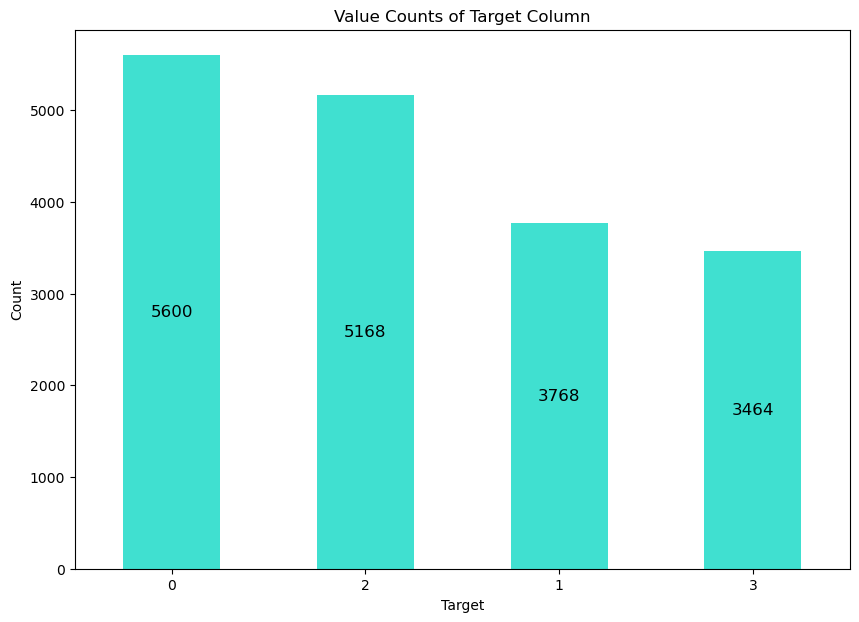

In [11]:
plt.figure(figsize=(10, 7))
ax = df.Target.value_counts().plot(kind='bar', color='Turquoise')

plt.title('Value Counts of Target Column')
plt.xlabel('Target')
plt.ylabel('Count')
plt.xticks(rotation=0)
ax.bar_label(ax.containers[0], fontsize=12, color='black', labels=df.Target.value_counts().values, label_type='center')

plt.show()


## Waveform representation of Audio file

#### original Audio Waveform

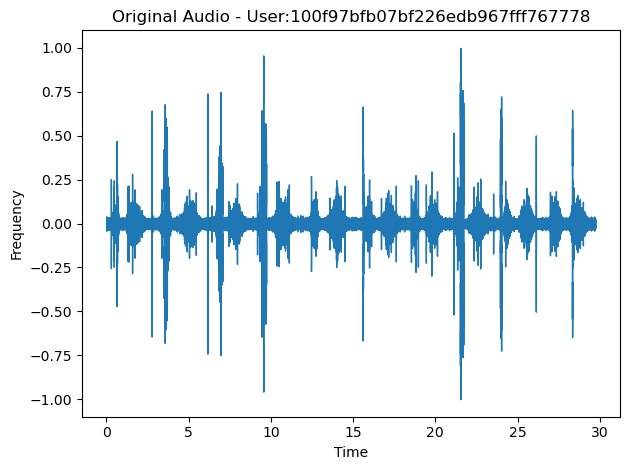

In [12]:
# Segment Audio waveform

fig, ax = plt.subplots()
librosa.display.waveshow(df.original_Audio[16], sr=df.Sample_Rate[20], ax= ax)
user = df.User_ID[16]
ax.set_title(f'Original Audio - User:{user}')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [13]:
ipd.Audio(df.original_Audio[16], rate = 8000)

#### Segment Waveform

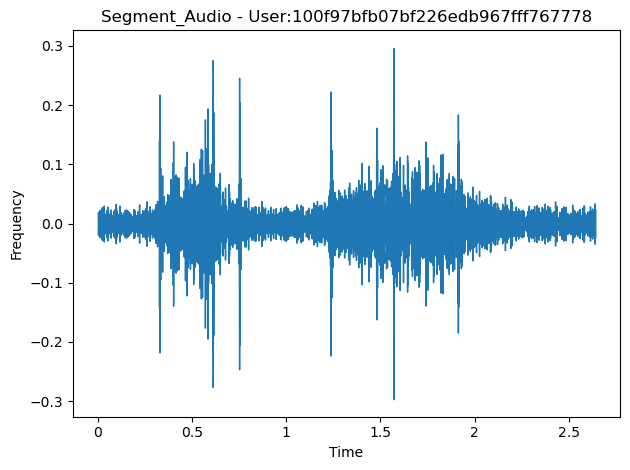

In [14]:
# Segment Audio waveform

fig, ax = plt.subplots()
librosa.display.waveshow(df.segment_audio[16], sr=df.Sample_Rate[7], ax= ax)
user = df.User_ID[16]
ax.set_title(f'Segment_Audio - User:{user}')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Padded Audio

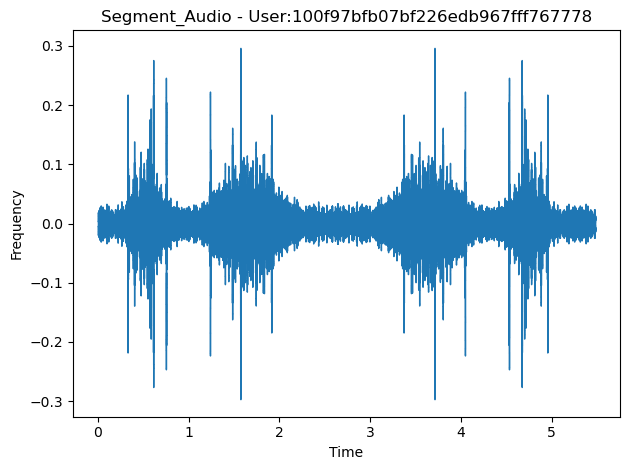

In [15]:
# Segment Audio waveform

fig, ax = plt.subplots()
librosa.display.waveshow(df.Padded_audio[16], sr=df.Sample_Rate[7], ax= ax)
user = df.User_ID[16]
ax.set_title(f'Segment_Audio - User:{user}')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Mel_Spectrogram

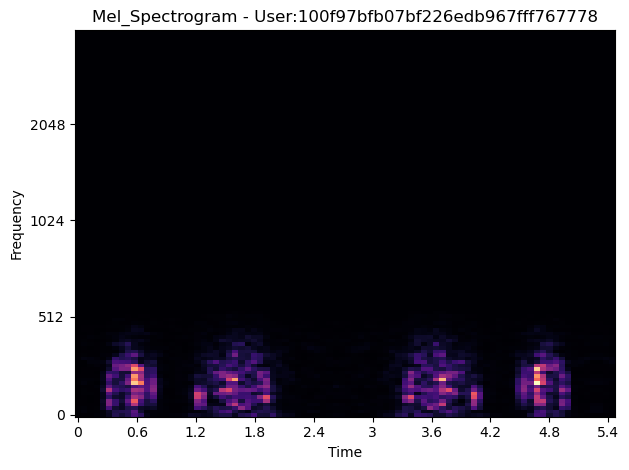

In [16]:
# Mel_spectrogram 

fig, ax = plt.subplots()
librosa.display.specshow(df.mel_spectrogram[16], sr= df.Sample_Rate[16], x_axis='time', y_axis='mel',hop_length=hop_length, ax =ax)
user = df.User_ID[16]
ax.set_title(f'Mel_Spectrogram - User:{user}')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### Mel_spectrogram in decibel scale

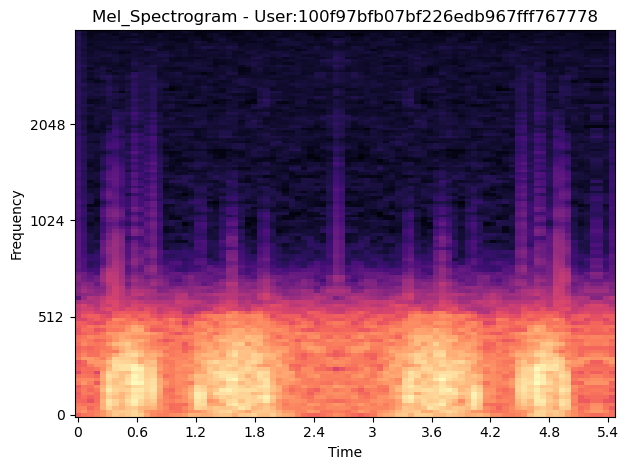

In [17]:
# Mel_spectrogram in decibel scale

fig, ax = plt.subplots()
librosa.display.specshow(df.mel_spectrogram_db[16], sr= df.Sample_Rate[16], x_axis='time', y_axis='mel',hop_length=hop_length, ax =ax)
user = df.User_ID[16]
ax.set_title(f'Mel_Spectrogram - User:{user}')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

#### MFCC Spectrogram

In [18]:
# # MFCC Spectogram 

# fig, ax = plt.subplots()
# librosa.display.specshow(df.MFCC[16], sr= df.Sample_Rate[16], x_axis='time', y_axis='mel',hop_length=hop_length, ax =ax)
# user = df.User_ID[16]
# ax.set_title(f'Mel_Spectrogram - User:{user}')
# ax.set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()

#### MFCC Spectrogram in Decimal Scale

In [19]:
# # MFCC Spectogram in Decimal Scale

# fig, ax = plt.subplots()
# librosa.display.specshow(df.Log_MFCC[16], sr= df.Sample_Rate[16], x_axis='time', y_axis='mel',hop_length=hop_length, ax =ax)
# user = df.User_ID[16]
# ax.set_title(f'Mel_Spectrogram - User:{user}')
# ax.set_ylabel('Frequency')

# plt.tight_layout()
# plt.show()

## Splitting the Data for Model training 

#### Length of the spectrogram

In [20]:
mel_spectrograms = [np.array(spec) for spec in df.mel_spectrogram_db]
max_sequence_length = max(len(spec) for spec in mel_spectrograms)

#### Width of the Spectrogram (number of time frames)

In [21]:
num_time_frames_list =[]

mel_spectrogram_sequences = df.mel_spectrogram_db
for spec in mel_spectrogram_sequences:
    num_time_frames = spec.shape[1]
    num_time_frames_list.append(num_time_frames)

max_width = max(num_time_frames_list)

#### Creating an 3D input array for the CNN 

In [22]:
x = np.zeros((len(mel_spectrogram_sequences), max_sequence_length, max_width))

####  Populating the input array with spectrogram data

In [23]:
for i, spec in enumerate(mel_spectrogram_sequences):
    x[i, :max_sequence_length, :spec.shape[1]] = spec  

In [24]:
y = np.array(df.Target)

#### Spliting the Data into Train and Validation Dataset

In [25]:
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.25, shuffle=False)
print(f'Train: {len(x_train)}', f'val: {len(x_val)}')

Train: 13500 val: 4500


In [26]:
x_train = np.array(x_train)
x_val = np.array(x_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

#### Spliting the Train Dataset into Train and Test Dataset

In [27]:
x_train, x_test, y_train, y_test = train_test_split(x_train, y_train, test_size=0.25,shuffle=False)
print(f'Train: {len(x_train)}', f'Test: {len(x_test)}')

Train: 10125 Test: 3375


#### Reshaping the Train and the Test Dataset

In [28]:
print('Orginal_Shapes:', x_train.shape, x_test.shape)

Orginal_Shapes: (10125, 128, 86) (3375, 128, 86)


In [29]:
x_train = x_train.reshape(x_train.shape[0], x_train.shape[1], x_train.shape[2], 1)
x_test = x_test.reshape(x_test.shape[0], x_test.shape[1], x_test.shape[2], 1)
print('Reshape:', x_train.shape, x_test.shape)

Reshape: (10125, 128, 86, 1) (3375, 128, 86, 1)


#### Taking input shape from the reshape

In [30]:
input_shape = x_train.shape[1:]

print('Input shape:', input_shape)

Input shape: (128, 86, 1)


## Creating CNN Model

#### Creating a Sequential model

In [31]:
model = models.Sequential()

#### Adding Convolutional layers to model

In [32]:
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(64, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

model.add(layers.Conv2D(128, (3, 3), activation='relu'))
model.add(layers.MaxPooling2D((2, 2)))
model.add(layers.Dropout(0.2))

#### Adding Flatten Layer

In [33]:
# Flatten layer to transition from convolutional to dense layers
model.add(layers.Flatten())

#### Adding Dense Layer

In [34]:
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dropout(0.2))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dropout(0.2))

#### Finally Adding Output Layer

In [35]:
# Output layer is for classification

num_classes = 4  # Number of Classes is the Target Variable 
model.add(layers.Dense(num_classes, activation='sigmoid'))

#### Model Compilling 

In [36]:
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

#### Model Summary

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 84, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 42, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 63, 42, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 40, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 20, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 30, 20, 64)        0

#### converting the class labels into hot encoded format.
hot encoding is a common technique used in classification tasks, where categorical labels are represented as binary vectors.

In [38]:
num_classes = 4
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)

#### Model Fitting

In [39]:
history = model.fit(x_train, y_train, epochs=16,  validation_data=(x_test, y_test))

Epoch 1/16
317/317 [==============================] - 8s 9ms/step - loss: 0.7713 - accuracy: 0.3172 - val_loss: 0.5652 - val_accuracy: 0.4225
Epoch 2/16
317/317 [==============================] - 2s 8ms/step - loss: 0.5144 - accuracy: 0.4408 - val_loss: 0.4684 - val_accuracy: 0.5393
Epoch 3/16
317/317 [==============================] - 2s 8ms/step - loss: 0.4119 - accuracy: 0.6063 - val_loss: 0.4177 - val_accuracy: 0.6213
Epoch 4/16
317/317 [==============================] - 2s 8ms/step - loss: 0.3595 - accuracy: 0.6723 - val_loss: 0.3301 - val_accuracy: 0.7173
Epoch 5/16
317/317 [==============================] - 2s 8ms/step - loss: 0.3263 - accuracy: 0.7073 - val_loss: 0.3020 - val_accuracy: 0.7384
Epoch 6/16
317/317 [==============================] - 2s 8ms/step - loss: 0.3069 - accuracy: 0

2023-09-28 17:41:45.369152: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:954] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer


#### Plotting the Accuracy Graph 

106/106 - 0s - loss: 0.2396 - accuracy: 0.7997 - 298ms/epoch - 3ms/step


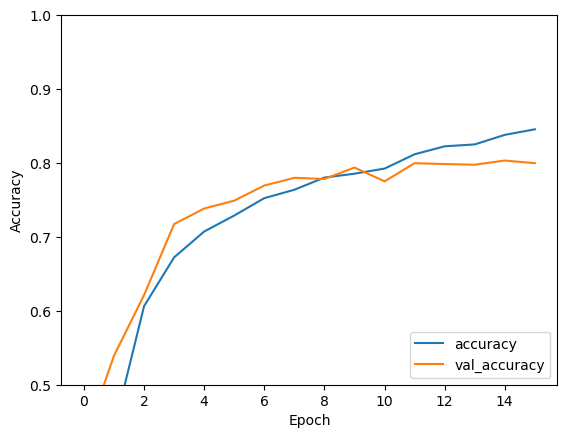

In [40]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

106/106 - 0s - loss: 0.2396 - accuracy: 0.7997 - 270ms/epoch - 3ms/step


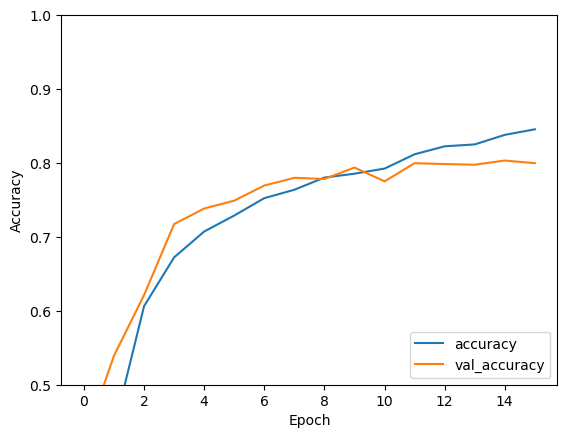

In [41]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_test,  y_test, verbose=2)

#### Evaluating the model on Train Dataset

In [42]:
train_loss, train_acc = model.evaluate(x_train,  y_train, verbose=2)
print('Train_Accuracy: ', train_acc, 'Train_Loss: ',train_loss)

317/317 - 1s - loss: 0.1469 - accuracy: 0.9062 - 767ms/epoch - 2ms/step
Train_Accuracy:  0.9061728119850159 Train_Loss:  0.1469179391860962


#### Evaluating the Model on Test Dataset

In [43]:
test_loss, test_acc = model.evaluate(x_test, y_test  , verbose=2)
print('Test_Accuracy: ', test_acc, 'Test_Loss: ',test_loss)

106/106 - 0s - loss: 0.2396 - accuracy: 0.7997 - 290ms/epoch - 3ms/step
Test_Accuracy:  0.7997037172317505 Test_Loss:  0.23957830667495728


#### Prediction on Validation Dataset

In [44]:
predictions = model.predict(x_val)
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

141/141 [==============================] - 0s 2ms/step
[0 0 0 ... 0 0 0]


#### Calculating the Accuracy of Validation Dataset

In [45]:
val_accuracy = accuracy_score(y_val, predicted_labels)

print(f"val_Accuracy: {val_accuracy:.2f}")


val_Accuracy: 0.81


#### Classification Report

In [46]:
report = classification_report(y_val,np.round(abs(predicted_labels)))
print('The Classification report is: \n',report)

The Classification report is: 
               precision    recall  f1-score   support

           0       0.84      0.95      0.90      1343
           1       0.81      0.74      0.78       968
           2       0.81      0.85      0.83      1404
           3       0.69      0.57      0.62       785

    accuracy                           0.81      4500
   macro avg       0.79      0.78      0.78      4500
weighted avg       0.80      0.81      0.80      4500



In [47]:
precision = precision_score(y_val, predicted_labels, average='weighted')
recall = recall_score(y_val, predicted_labels, average='weighted')
f1 = f1_score(y_val, predicted_labels, average='weighted')
accuracy = accuracy_score(y_val, predicted_labels)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")
print(f"Accuracy: {accuracy:.4f}")


Precision: 0.8026
Recall: 0.8076
F1-score: 0.8025
Accuracy: 0.8076


#### Plot of accuracy

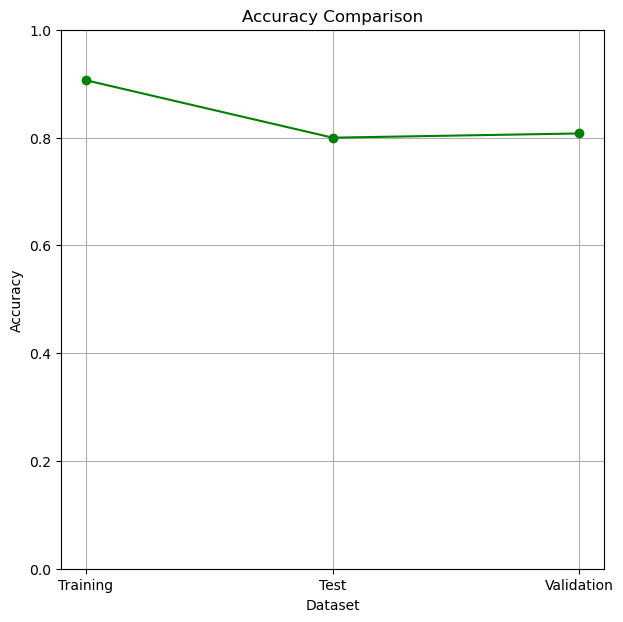

In [48]:
train_accuracy = train_acc  
test_accuracy = test_acc  
validation_accuracy = val_accuracy 

labels = ['Training', 'Test', 'Validation']

accuracies = [train_accuracy, test_accuracy, validation_accuracy]

plt.figure(figsize=(7, 7))
plt.plot(labels, accuracies, marker='o', linestyle='-', color='g')
plt.title('Accuracy Comparison')
plt.xlabel('Dataset')
plt.ylabel('Accuracy')
plt.ylim(0, 1)
plt.grid(True)
plt.show()

In [49]:
Test_audio = []

Test_audio = 'S0_M1.wav', 'S0_M2.wav', 'S0_M3.wav', 'S0_M4.wav', 'S0_M5.wav', 'S0_M6.wav', 'S0_M7.wav', 'S0_M8.wav'


In [104]:
TLdf = []


for i in Test_audio:
    Taudio , sr = librosa.load(i, sr=None)

    desired_duration = 5.48  
    desired_samples = int(desired_duration * 8000) 
           

    # Taudio = Taudio[:desired_samples]
    Taudio = Taudio[desired_samples:]


    Tmel = librosa.feature.melspectrogram(y = Taudio, sr=sr, n_fft=n_fft, hop_length=hop_length, n_mels=n_mels)

    # Converting an Mel amplitude spectrogram to the decibel scale. 

    Tmel_db = librosa.power_to_db(Tmel, ref=np.max)

    TLdf.append({
            'Taudio':Taudio,
            'Tmel' : Tmel,
            'Tmel_db':Tmel_db
            })

In [105]:
Tdf = pd.DataFrame(TLdf)
Tdf

,Taudio,Tmel,Tmel_db
0,"[-0.009979248, -0.009216309, -0.008422852, -0....","[[0.2469818, 0.249827, 0.21626668, 0.18446326,...","[[-22.986975, -22.93723, -23.563728, -24.25452..."
1,"[-0.0032348633, -0.0031433105, -0.0030212402, ...","[[0.28145278, 0.3503226, 0.44868708, 0.1869542...","[[-22.112862, -21.162235, -20.08748, -23.88956..."
2,"[-0.011993408, -0.011779785, -0.011474609, -0....","[[0.21486916, 0.23366486, 0.18253925, 0.187145...","[[-23.935228, -23.571035, -24.643406, -24.5351..."
3,"[-0.01361084, -0.012084961, -0.010253906, -0.0...","[[0.39800334, 0.31508648, 0.18130307, 0.186889...","[[-23.17592, -24.19049, -26.590736, -26.458946..."
4,"[0.036834717, 0.038635254, 0.03933716, 0.03897...","[[0.42219827, 0.39107656, 0.31236112, 0.791322...","[[-20.126724, -20.45927, -21.43532, -17.398352..."
5,"[-0.061340332, -0.05706787, -0.05227661, -0.04...","[[0.1890727, 0.24830638, 0.24802212, 0.2173812...","[[-24.169182, -22.985592, -22.990566, -23.5632..."
6,"[-0.031585693, -0.029144287, -0.026885986, -0....","[[1.874383, 1.2081847, 0.19015223, 0.19974363,...","[[-15.063235, -16.970486, -25.000805, -24.7870..."
7,"[-0.007843018, -0.0068969727, -0.00579834, -0....","[[0.28196692, 0.24339592, 0.27135938, 0.405312...","[[-20.626793, -21.26564, -20.793325, -19.05087..."


In [106]:
mel_spectrograms = [np.array(spec) for spec in Tdf.Tmel_db]
max_sequence_length = max(len(spec) for spec in mel_spectrograms)

In [107]:
num_time_frames_list =[]

mel_spectrogram_sequences = Tdf.Tmel_db
for spec in mel_spectrogram_sequences:
    num_time_frames = spec.shape[1]
    num_time_frames_list.append(num_time_frames)

max_width = max(num_time_frames_list)

In [108]:
x = np.zeros((len(mel_spectrogram_sequences), max_sequence_length, max_width))

In [109]:
for i, spec in enumerate(mel_spectrogram_sequences):
    x[i, :max_sequence_length, :spec.shape[1]] = spec  

In [110]:
pranay  = np.array(Tdf.Tmel_db)

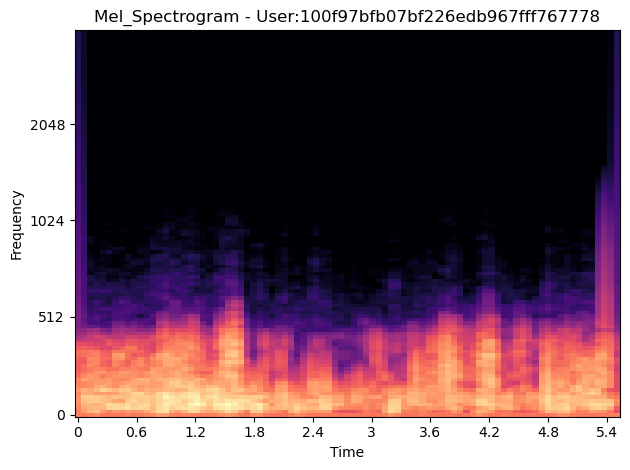

In [111]:
# Mel_spectrogram in decibel scale

fig, ax = plt.subplots()
librosa.display.specshow(Tdf.Tmel_db[7], sr= 8000, x_axis='time', y_axis='mel',hop_length=hop_length, ax =ax)
user = df.User_ID[16]
ax.set_title(f'Mel_Spectrogram - User:{user}')
ax.set_ylabel('Frequency')

plt.tight_layout()
plt.show()

In [112]:
x.shape

(8, 128, 87)

In [113]:
x = x.reshape(x.shape[0], x.shape[1], x.shape[2], 1)

In [114]:
x.shape

(8, 128, 87, 1)

In [115]:
predictions = model.predict(x)
predicted_labels = np.argmax(predictions, axis=1)
print(predicted_labels)

1/1 [==============================] - 0s 27ms/step
[3 0 0 1 0 3 3 0]
